In [ ]:
import os
import json
import random
import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, BertModel
from torchvision.models import ResNet50_Weights, resnet50
from sklearn.metrics import accuracy_score, classification_report, f1_score, top_k_accuracy_score
from tqdm import tqdm

DATASET_NAME = "flaviagiammarino/vqa-rad"
SPLITS_PATH = Path("vqarad_subset_splits.json")
SEED = 1337

SUBSET_FRAC = 1.0
VAL_FRAC = 0.15
TEST_FRAC = 0.15

EPOCHS = 15
BATCH_SIZE = 8
LR = 2e-5
MAX_QUESTION_LEN = 64

def set_seed(seed: int):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def get_device():
    """Returns the available device."""
    return "cuda" if torch.cuda.is_available() else "cpu"

# Initialize
set_seed(SEED)
device = get_device()
print(f"Running on {device} with {SUBSET_FRAC*100}% of data.")

Running on cpu with 100.0% of data.


In [ ]:
def normalize_text(s: str) -> str:
    return " ".join(s.lower().strip().split())

def load_or_create_subset_splits(
    dataset_name: str,
    *,
    subset_frac: float,
    seed: int,
    val_frac: float,
    test_frac: float,
    path: Path,
    force_regen: bool = False,
 ):
    """
    Create/load deterministic splits.
    """
    print(f"Loading {dataset_name}...")
    ds = load_dataset(dataset_name, split="train").shuffle(seed=seed)
    subset_size = max(3, int(len(ds) * subset_frac))
    subset_size = min(subset_size, len(ds))

    cfg = {
        "dataset_name": dataset_name,
        "seed": int(seed),
        "subset_frac": float(subset_frac),
        "val_frac": float(val_frac),
        "test_frac": float(test_frac),
        "subset_size": int(subset_size),
    }

    def make_indices():
        rng = np.random.RandomState(seed)
        perm = rng.permutation(subset_size).tolist()
        n_val = max(1, int(round(subset_size * val_frac)))
        n_test = max(1, int(round(subset_size * test_frac)))
        n_train = subset_size - n_val - n_test
        if n_train < 1:
            n_train = 1
            remain = subset_size - n_train
            n_val = max(1, min(n_val, max(1, remain - 1)))
            n_test = max(1, remain - n_val)
        return {
            "train": perm[:n_train],
            "val": perm[n_train : n_train + n_val],
            "test": perm[n_train + n_val :],
        }

    if path.exists() and not force_regen:
        cached = json.loads(path.read_text(encoding="utf-8"))
        old_cfg = cached.get("config", {})
        same_cfg = all(old_cfg.get(k) == cfg.get(k) for k in cfg.keys())
        indices = cached["indices"] if same_cfg else make_indices()
        if not same_cfg:
            path.write_text(json.dumps({"config": cfg, "indices": indices}, indent=2), encoding="utf-8")
    else:
        indices = make_indices()
        path.write_text(json.dumps({"config": cfg, "indices": indices}, indent=2), encoding="utf-8")

    train_ds = ds.select(indices["train"])
    val_ds = ds.select(indices["val"])
    test_ds = ds.select(indices["test"])
    return train_ds, val_ds, test_ds

# Load Data & Build Vocab
train_ds, val_ds, test_ds = load_or_create_subset_splits(
    DATASET_NAME,
    subset_frac=SUBSET_FRAC,
    seed=SEED,
    val_frac=VAL_FRAC,
    test_frac=TEST_FRAC,
    path=SPLITS_PATH,
 )
print(f"subset sizes | train={len(train_ds)} val={len(val_ds)} test={len(test_ds)}")

def build_answer_vocab(train_ds):
    answers = [normalize_text(a) for a in train_ds["answer"]]
    uniq = sorted(set(answers))
    answer_to_id = {a: i for i, a in enumerate(uniq)}
    if "<unk>" not in answer_to_id:
        answer_to_id["<unk>"] = len(answer_to_id)
    id_to_answer = {i: a for a, i in answer_to_id.items()}
    return answer_to_id, id_to_answer

answer_to_id, id_to_answer = build_answer_vocab(train_ds)
print(f"Vocab size: {len(answer_to_id)}")

Loading flaviagiammarino/vqa-rad...
subset sizes | train=1255 val=269 test=269
Vocab size: 357


In [14]:
weights = ResNet50_Weights.IMAGENET1K_V2
image_transform = weights.transforms()
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

class VqaRadDataset(Dataset):
    def __init__(self, dataset, tokenizer, image_transform, answer_to_id):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.answer_to_id = answer_to_id

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"].convert("RGB")
        pixel_values = self.image_transform(image)
        question = normalize_text(item["question"])
        encoding = self.tokenizer(
            question, padding="max_length", truncation=True,
            max_length=MAX_QUESTION_LEN, return_tensors="pt"
        )
        ans_text = normalize_text(item["answer"])
        label = self.answer_to_id.get(ans_text, self.answer_to_id["<unk>"])
        return {
            "pixel_values": pixel_values,
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

train_loader = DataLoader(VqaRadDataset(train_ds, tokenizer, image_transform, answer_to_id),
                          batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(VqaRadDataset(val_ds, tokenizer, image_transform, answer_to_id),
                        batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(VqaRadDataset(test_ds, tokenizer, image_transform, answer_to_id),
                         batch_size=BATCH_SIZE, shuffle=False)

In [15]:
class ImprovedResNetBertVQA(nn.Module):
    def __init__(self, num_answers, hidden_dim=512, dropout=0.3):
        super().__init__()
        # Image
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.img_enc = nn.Sequential(*list(resnet.children())[:-1])
        # Text
        self.txt_enc = BertModel.from_pretrained("bert-base-uncased")
        # Projections
        self.img_proj = nn.Linear(2048, hidden_dim)
        self.txt_proj = nn.Linear(768, hidden_dim)
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_answers)
        )

    def forward(self, pixel_values, input_ids, mask):
        img = self.img_proj(self.img_enc(pixel_values).flatten(1))
        txt = self.txt_proj(self.txt_enc(input_ids, mask).last_hidden_state[:, 0, :])
        # Optimization: Element-wise multiplication
        return self.classifier(img * txt)

In [16]:
def train_model_with_history():
    model = ImprovedResNetBertVQA(num_answers=len(answer_to_id)).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0
    best_path = "best_model_optimized.pth"

    # HISTORY STORAGE
    history = {
        "train_loss": [],
        "val_acc": []
    }

    print(f"Starting Training for {EPOCHS} epochs...")
    for epoch in range(1, EPOCHS+1):
        # --- TRAINING ---
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
            for k, v in batch.items(): batch[k] = v.to(device)
            optimizer.zero_grad()
            logits = model(batch["pixel_values"], batch["input_ids"], batch["attention_mask"])
            loss = criterion(logits, batch["label"])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss)

        scheduler.step()

        # --- VALIDATION ---
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                for k, v in batch.items(): batch[k] = v.to(device)
                logits = model(batch["pixel_values"], batch["input_ids"], batch["attention_mask"])
                preds = logits.argmax(dim=1)
                correct += (preds == batch["label"]).sum().item()
                total += batch["label"].size(0)

        val_acc = correct / total
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), best_path)

    return best_path, history

# Run training and get history
best_model_file, history = train_model_with_history()

Starting Training for 15 epochs...


Epoch 1: 100%|██████████| 157/157 [02:09<00:00,  1.21it/s]


Epoch 1 | Loss: 5.0455 | Val Acc: 0.3643


Epoch 2: 100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Epoch 2 | Loss: 3.3953 | Val Acc: 0.3643


Epoch 3: 100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Epoch 3 | Loss: 3.2620 | Val Acc: 0.3569


Epoch 4: 100%|██████████| 157/157 [02:10<00:00,  1.20it/s]


Epoch 4 | Loss: 3.2027 | Val Acc: 0.3866


Epoch 5: 100%|██████████| 157/157 [02:09<00:00,  1.21it/s]


Epoch 5 | Loss: 3.0782 | Val Acc: 0.3978


Epoch 6: 100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Epoch 6 | Loss: 2.9533 | Val Acc: 0.4275


Epoch 7: 100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Epoch 7 | Loss: 2.7968 | Val Acc: 0.4387


Epoch 8: 100%|██████████| 157/157 [02:09<00:00,  1.22it/s]


Epoch 8 | Loss: 2.7253 | Val Acc: 0.4535


Epoch 9: 100%|██████████| 157/157 [02:09<00:00,  1.21it/s]


Epoch 9 | Loss: 2.6229 | Val Acc: 0.4461


Epoch 10: 100%|██████████| 157/157 [02:09<00:00,  1.21it/s]


Epoch 10 | Loss: 2.5572 | Val Acc: 0.4498


Epoch 11: 100%|██████████| 157/157 [02:09<00:00,  1.21it/s]


Epoch 11 | Loss: 2.4796 | Val Acc: 0.4498


Epoch 12: 100%|██████████| 157/157 [02:09<00:00,  1.21it/s]


Epoch 12 | Loss: 2.4265 | Val Acc: 0.4498


Epoch 13: 100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Epoch 13 | Loss: 2.4022 | Val Acc: 0.4535


Epoch 14: 100%|██████████| 157/157 [02:09<00:00,  1.21it/s]


Epoch 14 | Loss: 2.3811 | Val Acc: 0.4535


Epoch 15: 100%|██████████| 157/157 [02:10<00:00,  1.20it/s]


Epoch 15 | Loss: 2.3744 | Val Acc: 0.4572


In [23]:
def evaluate_metrics(model_path):
    print("\n--- Final Evaluation ---")
    model = ImprovedResNetBertVQA(num_answers=len(answer_to_id))
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    all_logits = []

    with torch.no_grad():
        for batch in test_loader:
            for k, v in batch.items(): batch[k] = v.to(device)
            logits = model(batch["pixel_values"], batch["input_ids"], batch["attention_mask"])
            preds = logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["label"].cpu().numpy())
            all_logits.extend(logits.cpu().numpy())

    # Standard Accuracy
    acc = accuracy_score(all_labels, all_preds)

    # Weighted F1 Score (Good for imbalanced data)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Top-5 Accuracy
    try:
        top5 = top_k_accuracy_score(all_labels, np.array(all_logits), k=5, labels=range(len(answer_to_id)))
    except:
        top5 = 0.0 # Fallback if k > n_classes

    print(f"Accuracy:        {acc:.4f}")
    print(f"Weighted F1:     {f1:.4f}")
    print(f"Top-5 Accuracy:  {top5:.4f}")

    # Detailed Report (Precision/Recall per class)
    present_indices = sorted(list(set(all_labels) | set(all_preds)))
    present_names = [id_to_answer[i] for i in present_indices]

    print("\n--- Detailed Classification Report ---")
    print(classification_report(all_labels, all_preds, labels=present_indices, target_names=present_names, zero_division=0))

evaluate_metrics(best_model_file)


--- Final Evaluation ---
Accuracy:        0.4052
Weighted F1:     0.3844
Top-5 Accuracy:  0.5948

--- Detailed Classification Report ---
                                                  precision    recall  f1-score   support

                                   4th ventricle       0.00      0.00      0.00         1
                                            5 cm       0.00      0.00      0.00         1
            5.6cm focal, predominantly hypodense       1.00      1.00      1.00         1
                                         7th rib       0.00      0.00      0.00         1
                                          abcess       0.00      0.00      0.00         1
                                 air fluid level       0.00      0.00      0.00         1
                                         ascites       0.00      0.00      0.00         1
                                           axial       0.45      1.00      0.62         5
                                   basal ganglia   

In [18]:
def evaluate_open_closed_inferred(model_path):
    print("\n--- Open vs. Closed Question Evaluation ---")

    # Load Model
    model = ImprovedResNetBertVQA(num_answers=len(answer_to_id))
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    # Get predictions and labels
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            for k, v in batch.items(): batch[k] = v.to(device)
            logits = model(batch["pixel_values"], batch["input_ids"], batch["attention_mask"])
            preds = logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["label"].cpu().numpy())

    # Infer Question Types (Since 'answer_type' column is missing)
    raw_answers = [normalize_text(a) for a in test_ds["answer"]]

    closed_indices = []
    open_indices = []

    for i, ans in enumerate(raw_answers):
        if ans in ["yes", "no"]:
            closed_indices.append(i)
        else:
            open_indices.append(i)

    print(f"\nInferred {len(closed_indices)} Closed (Yes/No) and {len(open_indices)} Open questions.")

    # Calculate accuracy for each subset
    def calc_subset_acc(indices, name):
        if not indices:
            print(f"{name} Accuracy: N/A (0 samples)")
            return

        subset_preds = [all_preds[i] for i in indices]
        subset_labels = [all_labels[i] for i in indices]

        acc = accuracy_score(subset_labels, subset_preds)
        print(f"{name} Accuracy: {acc:.4f} ({len(indices)} samples)")

    # Print Results
    calc_subset_acc(closed_indices, "Closed-Ended (Binary)")
    calc_subset_acc(open_indices, "Open-Ended (Free text)")

    # Overall
    total_acc = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Accuracy: {total_acc:.4f}")

# Run the split evaluation
evaluate_open_closed_inferred(best_model_file)


--- Open vs. Closed Question Evaluation ---


Predicting: 100%|██████████| 34/34 [00:09<00:00,  3.44it/s]


Inferred 145 Closed (Yes/No) and 124 Open questions.
Closed-Ended (Binary) Accuracy: 0.6759 (145 samples)
Open-Ended (Free text) Accuracy: 0.0887 (124 samples)

Overall Accuracy: 0.4052


## Plot Graphs

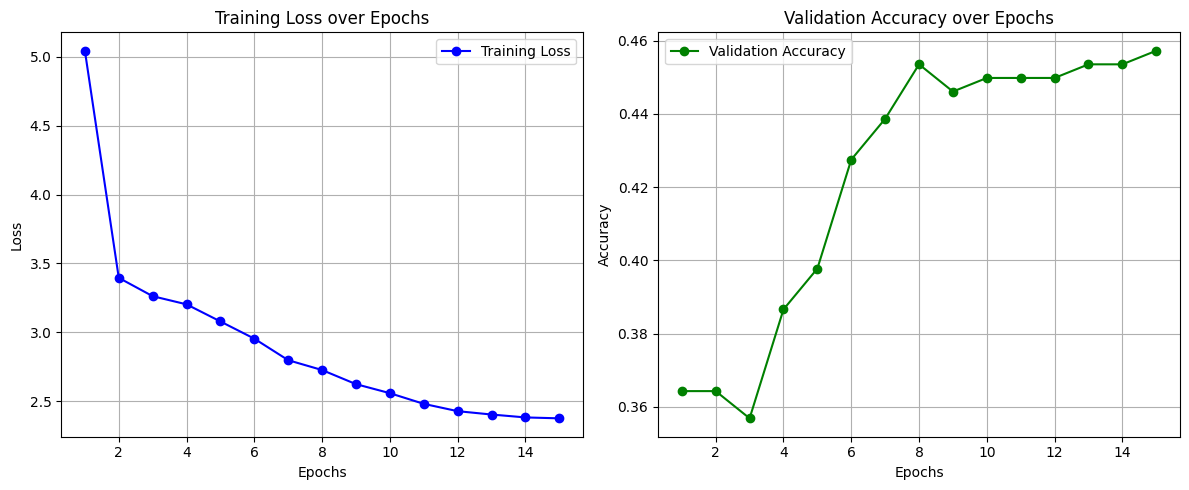

In [19]:
import matplotlib.pyplot as plt

def plot_evaluation_curves(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Plot 1: Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], 'b-o', label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot 2: Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["val_acc"], 'g-o', label='Validation Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Generate plots
plot_evaluation_curves(history)

## Enhanced Evaluation (Optional)

Adds the same style of analysis used in the final VLM notebook:
- Open vs closed breakdown (already present, but re-packaged into a reusable function)
- Per-question-type breakdown (heuristic)
- CSV export for human annotation

In [ ]:
import csv
from collections import defaultdict
from pathlib import Path

def categorize_question_type(question: str) -> str:
    q = (question or "").lower()
    if "how many" in q or "count" in q:
        return "counting"
    if any(w in q for w in ["is ", "is there", "does ", "are ", "can "]):
        return "yes_no"
    if any(w in q for w in ["what", "which", "where"]):
        if "modality" in q or "imaging" in q:
            return "modality"
        if any(organ in q for organ in ["brain", "heart", "lung", "liver", "kidney"]):
            return "organ"
        if any(w in q for w in ["abnormal", "disease", "mass", "fracture", "pneumonia"]):
            return "abnormality"
        return "what_other"
    return "other"

@torch.no_grad()
def collect_logits_and_labels_for_loader(model: nn.Module, loader: DataLoader):
    model.eval()
    all_logits = []
    all_labels = []
    for batch in loader:
        for k, v in batch.items():
            batch[k] = v.to(device)
        logits = model(batch["pixel_values"], batch["input_ids"], batch["attention_mask"])
        all_logits.append(logits.detach().cpu())
        all_labels.append(batch["label"].detach().cpu())
    if not all_logits:
        return torch.empty((0, 0)), torch.empty((0,), dtype=torch.long)
    return torch.cat(all_logits, dim=0), torch.cat(all_labels, dim=0)

def inferred_open_closed_indices(hf_ds):
    raw_answers = [normalize_text(a) for a in hf_ds["answer"]]
    closed = [i for i, a in enumerate(raw_answers) if a in {"yes", "no"}]
    open_ = [i for i, a in enumerate(raw_answers) if a not in {"yes", "no"}]
    return closed, open_

def per_question_type_accuracy(*, hf_ds, preds: list[int], labels: list[int]) -> dict[str, dict[str, float]]:
    buckets = defaultdict(lambda: {"preds": [], "labels": []})
    for i, (p, y) in enumerate(zip(preds, labels)):
        qt = categorize_question_type(hf_ds[i]["question"])
        buckets[qt]["preds"].append(p)
        buckets[qt]["labels"].append(y)

    out: dict[str, dict[str, float]] = {}
    for qt, data in buckets.items():
        acc = float(np.mean([int(p == y) for p, y in zip(data["preds"], data["labels"])]) ) if data["preds"] else 0.0
        out[qt] = {"accuracy": acc, "count": float(len(data["preds"]))}
    return out

def export_predictions_for_human_eval(*, hf_ds, logits: np.ndarray, output_csv: Path, topk: int = 5, n_samples: int | None = None):
    output_csv.parent.mkdir(parents=True, exist_ok=True)
    preds = logits.argmax(axis=1).tolist() if logits.size else []
    idxs = list(range(len(preds)))
    if n_samples is not None:
        rng = np.random.RandomState(1337)
        idxs = rng.choice(idxs, size=min(n_samples, len(idxs)), replace=False).tolist()

    with open(output_csv, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["sample_id", "question", "reference", "prediction", "question_type", "topk_predictions", "human_correctness", "human_notes"])
        for i in idxs:
            q = hf_ds[i]["question"]
            ref = hf_ds[i]["answer"]
            pred_text = id_to_answer.get(preds[i], "<unk>")
            top_ids = np.argsort(-logits[i])[: min(topk, logits.shape[1])].tolist() if logits.size else []
            topk_texts = [id_to_answer.get(t, "<unk>") for t in top_ids]
            w.writerow([i, q, ref, pred_text, categorize_question_type(q), "|".join(topk_texts), "", ""])
    print(f"[human-eval] wrote {len(idxs)} rows to {output_csv}")

# Final Evaluation with detailed metrics
model = ImprovedResNetBertVQA(num_answers=len(answer_to_id)).to(device)
model.load_state_dict(torch.load(best_model_file, map_location=device))

test_logits_t, test_labels_t = collect_logits_and_labels_for_loader(model, test_loader)
test_logits = test_logits_t.numpy()
test_preds = test_logits_t.argmax(dim=1).tolist()
test_labels = test_labels_t.tolist()

closed_idx, open_idx = inferred_open_closed_indices(test_ds)
print(f"Closed n={len(closed_idx)} | Open n={len(open_idx)}")
if closed_idx:
    print("Closed acc:", float(np.mean([int(test_preds[i]==test_labels[i]) for i in closed_idx])))
if open_idx:
    print("Open acc:", float(np.mean([int(test_preds[i]==test_labels[i]) for i in open_idx])))

print("Per-question-type:")
for qt, m in sorted(per_question_type_accuracy(hf_ds=test_ds, preds=test_preds, labels=test_labels).items()):
    print(qt, m)

Closed n=145 | Open n=124
Closed acc: 0.6758620689655173
Open acc: 0.08870967741935484
Per-question-type:
abnormality {'accuracy': 0.0, 'count': 3.0}
counting {'accuracy': 1.0, 'count': 1.0}
modality {'accuracy': 0.0, 'count': 2.0}
organ {'accuracy': 0.0, 'count': 1.0}
other {'accuracy': 0.5833333333333334, 'count': 12.0}
what_other {'accuracy': 0.0, 'count': 6.0}
yes_no {'accuracy': 0.4139344262295082, 'count': 244.0}


In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Compact metrics calculation
y_true = np.array(test_labels)
y_pred = np.array(test_preds)
acc = float((y_true == y_pred).mean())
f1 = float(f1_score(y_true, y_pred, average="weighted", zero_division=0))

# Top-5 accuracy
logits = np.array(test_logits)
top5 = float((np.argsort(-logits, axis=1)[:, :5] == y_true[:, None]).any(axis=1).mean())

print(f"Test Accuracy:   {acc:.4f}")
print(f"Weighted F1:     {f1:.4f}")
print(f"Top-5 Accuracy:  {top5:.4f}")

Test Accuracy:   0.4052
Weighted F1:     0.3844
Top-5 Accuracy:  0.5948
